# Step 3 - Prepare points of interest (POI) data
## Project: Growing Urban Bicycle Networks - with an LTN twist

This notebook downloads and prepares points of interest data to be used for bicycle network design, snapping them to the networks created in 02_prepare_networks. POIs (also called seed points) can be set using: 
* LTNs
* Hexagonal Tesselations within city boundary and external to LTNs
* railway stations
* grid points


Contact:  Chris Larkin (c.larkin@ncl.ac.uk) 

Created: 2020-07-07  
Last modified: 2024-11-08

## Preliminaries

### Setup

In [31]:
%run -i path.py
%run -i setup.py

%load_ext watermark
#%watermark -n -v -m -g -iv
PATH['exports_gpkg'] = '../../bikenwgrowth_external/exports_gpkg/'

Loaded PATH.



=== Cities ===
{   'newcastle': {   'countryid': 'gbr',
                     'name': 'Newcastle Upon Tyne',
                     'nominatimstring': 'Newcastle Upon Tyne'}}


Setup finished.

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


### Parameters

In [32]:
debug = True # If True, will produce plots and/or verbose output to double-check
%run -i "../parameters/parameters.py"

Loaded parameters.



### Functions

In [33]:
%run -i functions.py

Loaded functions.



## Download and wrangle data

In [34]:
# Load all carall graphs in OSMNX format
G_caralls = {}
G_caralls_simplified = {}
G_biketracks = {}
locations = {}
parameterinfo = osmnxparameters['carall']

for placeid, placeinfo in tqdm(cities.items(), desc = "Cities"):
    print(placeid + ": Loading location polygon and carall graph")
    
    if placeinfo["nominatimstring"] != '':
        location = ox.geocoder.geocode_to_gdf(placeinfo["nominatimstring"])
        if location.geometry[0].geom_type == 'MultiPolygon':
            location = location.explode(index_parts=False).reset_index(drop=True)
        location = fill_holes(extract_relevant_polygon(placeid, shapely.geometry.shape(location['geometry'][0])))
    else:
        # https://gis.stackexchange.com/questions/113799/how-to-read-a-shapefile-in-python
        shp = fiona.open(PATH["data"] + placeid + "/" + placeid + ".shp")
        first = next(iter(shp))
        try:
            location = Polygon(shapely.geometry.shape(first['geometry'])) # If shape file is given as linestring
        except:
            location = shapely.geometry.shape(first['geometry'])
    locations[placeid] = location
    
    G_caralls[placeid] = csv_to_ox(PATH["data"] + placeid + "/", placeid, 'carall')
    G_caralls[placeid].graph["crs"] = 'epsg:4326' # needed for OSMNX's graph_to_gdfs in utils_graph.py
    G_caralls_simplified[placeid] = csv_to_ox(PATH["data"] + placeid + "/", placeid, 'carall_simplified')
    G_caralls_simplified[placeid].graph["crs"] = 'epsg:4326' # needed for OSMNX's graph_to_gdfs in utils_graph.py

    G_biketracks[placeid] = csv_to_ox(PATH["data"] + placeid + "/", placeid, 'biketrack')
    G_biketracks[placeid].graph["crs"] = 'epsg:4326' # needed for OSMNX's graph_to_gdfs in utils_graph.py

Cities:   0%|          | 0/1 [00:00<?, ?it/s]

newcastle: Loading location polygon and carall graph


### Tessellation

In [35]:
## Old code, remove later

# for placeid, placeinfo in tqdm(cities.items(), desc  = "Cities"):
#     print(placeid + ": Tesselation around neighbourhoods")
#     location = locations[placeid]
    
#     # get urban areas - we want seed points where people live, not countryside!
#     urban_areas = get_urban_areas(placeinfo["nominatimstring"])
    
#     tess = Tessellation(urban_areas) 
#     # if an error, add this line to the tessypy libarary: 
#     # df_qk_squares = df_qk_squares.drop(columns=["osm_id", "children_id"], errors='ignore')
#     tess.get_polygon()#.plot(figsize=(10, 10)).set_axis_off();
#     hexagons = tess.hexagons(resolution=8)
#     if debug:
#         hexagons.plot(lw=1, edgecolor="w", figsize=(10, 10)).set_axis_off();


#     # load any LTNs
#     neighbourhoods = load_neighbourhoods(PATH["data"] + placeid + "/")

#     # cut out ltns from neighbourhood boundary
#     neighbourhood_geoms = []
#     for gdf in neighbourhoods.values():
#         neighbourhood_geoms.extend(gdf['geometry'].values)
#     neighbourhoods_gdf = MultiPolygon(neighbourhood_geoms)
#     for neighbourhood_geom in neighbourhoods_gdf.geoms:
#         location = location.difference(neighbourhood_geom)
    
#     # set as a geodataframe
#     location_gseries = gpd.GeoSeries([location])
#     location_gdf = gpd.GeoDataFrame(geometry=location_gseries)
#     location_gdf = location_gdf.set_crs(epsg=4326, inplace=True)

#     # remove any hexagons which intersect with the neighbourhoods
#     hexagons = hexagons[~hexagons.intersects(gdf.unary_union)]
#     hexagon_centroids_gdf = gpd.GeoDataFrame(geometry=hexagons.centroid, crs=hexagons.crs)
#     if debug:
#         hexagon_centroids_gdf.plot(color='blue')






#     print(placeid + ": loading and moving POIs")
#     # We need the carall graph and location geometry
#     G_carall = G_caralls_simplified[placeid]
#     try:
#         gdf = hexagon_centroids_gdf
#         print(gdf.crs)

#         # Now snap to closest nodes in the street network and save the nearest node ids
#         nnids = set()
#         for g in gdf['geometry']:
#             # Find nearest node in the carall network
#             n = ox.distance.nearest_nodes(G_carall, g.x, g.y)
#             if n not in nnids and haversine((g.y, g.x), (G_carall.nodes[n]["y"], G_carall.nodes[n]["x"]), unit="m") <= snapthreshold:
#                 nnids.add(n)
#         nnids_csv_path = PATH["data"] + placeid + "/" + placeid + '_poi_' + 'tessellation' + '_nnidscarall.csv'
#         with open(nnids_csv_path, 'w') as f:
#             for item in nnids:
#                 f.write("%s\n" % item)

#         gdf = gdf.apply(lambda c: c.astype(str) if c.name != 'geometry' else c, axis=0)
#         gpkg_output_path = PATH["data"] + placeid + "/" + placeid + '_poi_' + 'tessellation' + '.gpkg'
#         try:
#             gdf.to_file(gpkg_output_path, driver='GPKG')
#         except Exception as e:
#             print(f"Notice: Writing the tesselation gdf did not work for {placeid}. Error: {e}")

#         # Optionally plot for debugging purposes
#         if debug:
#             gdf.plot(color='red')

#     except Exception as e:
#         print(f"No points created for {placeinfo['name']}. No POIs created. Error: {e}")


In [36]:
neighbourhoods = load_neighbourhoods(PATH["data"] + placeid + "/")

1 Cities loaded


In [37]:
# location_gseries = gpd.GeoSeries([location])
# location_gdf = gpd.GeoDataFrame(geometry=location_gseries)
# location_gdf = location_gdf.set_crs(epsg=4326, inplace=True)

# # Get urban areas for seed points
# urban_areas = get_urban_areas(placeinfo["nominatimstring"])
# urban_areas = urban_areas.clip(location_gdf.unary_union)
#debug = True

Cities:   0%|          | 0/1 [00:00<?, ?it/s]

newcastle: Tesselation around neighbourhoods


C:\Users\b8008458\OneDrive - Newcastle University\2022 to 2023\PhD\networkGrowth\bikenwgrowth\code\functions.py:2279: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_buffered['geometry'] = gdf['geometry'].buffer(buffer_distance)


1 Cities loaded


C:\Users\b8008458\AppData\Local\Temp\ipykernel_30464\2342209336.py:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hexagon_centroids_gdf = gpd.GeoDataFrame(geometry=hexagons.centroid, crs=hexagons.crs)


newcastle: loading and moving POIs


C:\Users\b8008458\AppData\Local\Temp\ipykernel_30464\2342209336.py:81: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  neighbourhoods_gdf_for_plotting = neighbourhoods_gdf_for_plotting.explode()
C:\Users\b8008458\AppData\Local\Temp\ipykernel_30464\2342209336.py:84: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


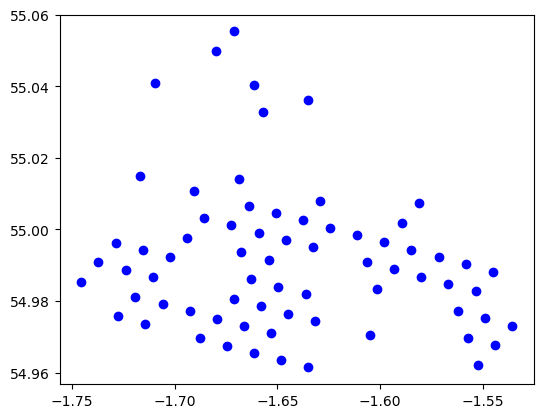

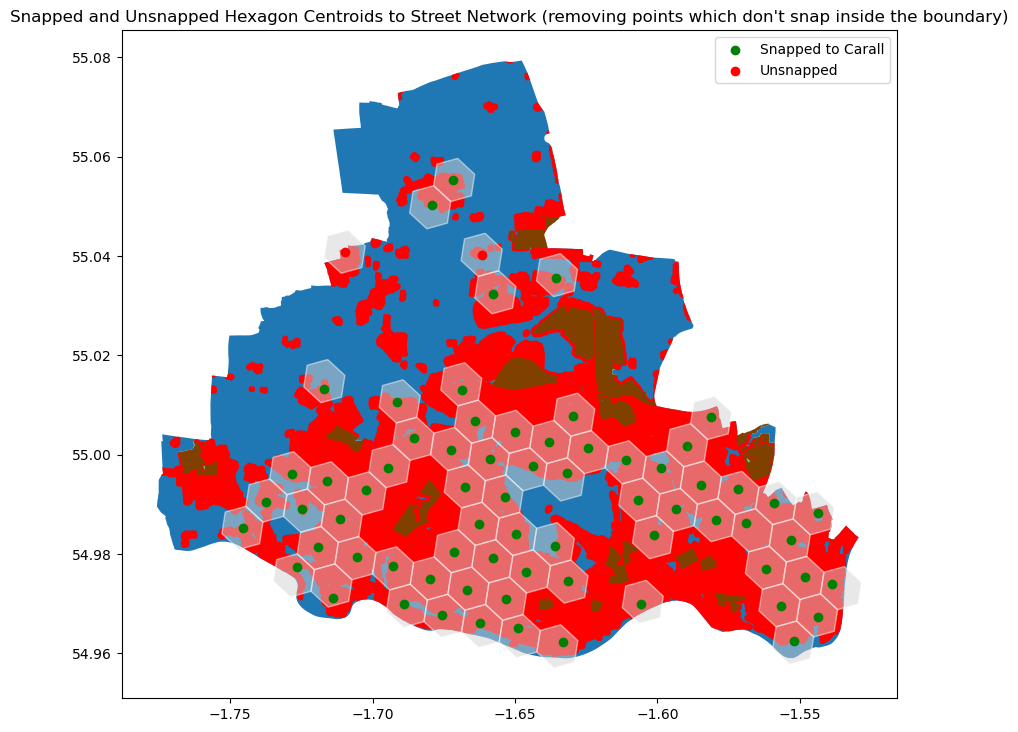

newcastle: Snapping to bike tracks


C:\Users\b8008458\AppData\Local\Temp\ipykernel_30464\2342209336.py:128: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


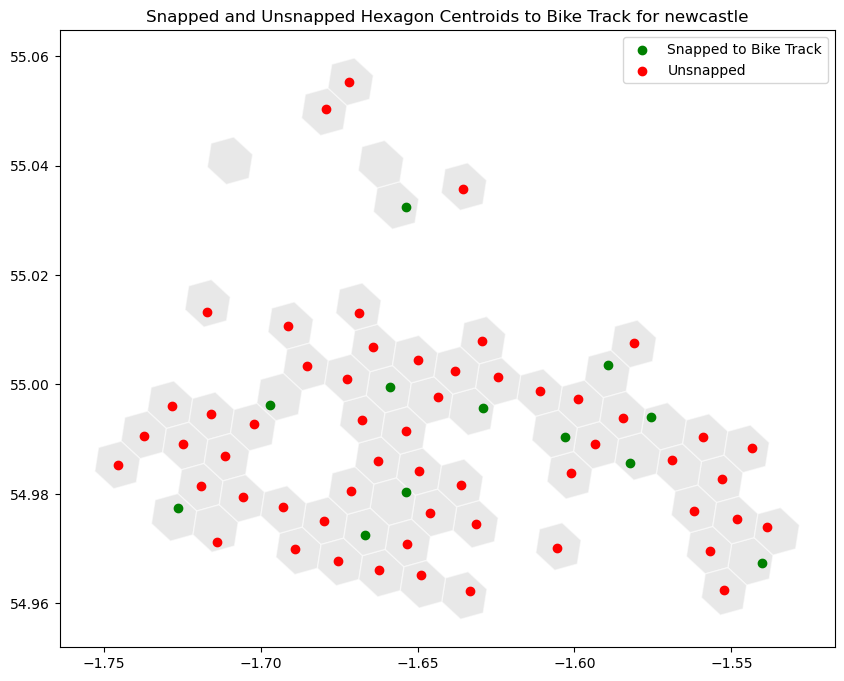

In [38]:
# get POIs based on hexagonal tessellation within the city boundary whilst excluding LTNs

for placeid, placeinfo in tqdm(cities.items(), desc="Cities"):
    print(placeid + ": Tesselation around neighbourhoods")
    location = locations[placeid]

    location_gseries = gpd.GeoSeries([location])
    location_gdf = gpd.GeoDataFrame(geometry=location_gseries)
    location_gdf = location_gdf.set_crs(epsg=4326, inplace=True)

    # Get urban areas for seed points
    urban_areas = get_urban_areas(placeinfo["nominatimstring"])
    urban_areas = urban_areas.clip(location_gdf.unary_union)

    tess = Tessellation(urban_areas)
    tess.get_polygon()  # Optional plot for debugging
    hexagons = tess.hexagons(resolution=8)
    clean_hexagons = hexagons # save a copy for later!
    if export:
        file_path = os.path.join(PATH["exports_gpkg"] + placeid + "/" + f"{placeid}_clean_hexagons.gpkg"); os.makedirs(os.path.dirname(file_path), exist_ok=True)
        hexagons.to_file(file_path, driver="GPKG")

    
    # Load LTNs
    neighbourhoods = load_neighbourhoods(PATH["data"] + placeid + "/")
    neighbourhood_geoms = [geom for gdf in neighbourhoods.values() for geom in gdf['geometry'].values]
    neighbourhoods_gdf = MultiPolygon(neighbourhood_geoms)
    for neighbourhood_geom in neighbourhoods_gdf.geoms:
        location = location.difference(neighbourhood_geom)
    
    # Set location as a GeoDataFrame
    location_gdf = gpd.GeoDataFrame(geometry=[location], crs="EPSG:4326")
    
    # Remove hexagons that intersect with neighbourhoods
    hexagons = hexagons[~hexagons.intersects(neighbourhoods_gdf)]
    hexagon_centroids_gdf = gpd.GeoDataFrame(geometry=hexagons.centroid, crs=hexagons.crs)
    if export:
        file_path = os.path.join(PATH["exports_gpkg"] + placeid + "/" + f"{placeid}_hexagons.gpkg"); os.makedirs(os.path.dirname(file_path), exist_ok=True)
        hexagons.to_file(file_path, driver="GPKG")
        file_path = os.path.join(PATH["exports_gpkg"] + placeid + "/" + f"{placeid}_hexagon_centriods.gpkg"); os.makedirs(os.path.dirname(file_path), exist_ok=True)
        hexagon_centroids_gdf.to_file(file_path, driver="GPKG")
    
    if debug:
        hexagon_centroids_gdf.plot(color='blue')

    print(placeid + ": loading and moving POIs")
    # load networks
    G_carall = G_caralls_simplified[placeid]
    G_biketrack = G_biketracks[placeid]
    
    # First snap points to the carall network
    updated_points = []
    for g in hexagon_centroids_gdf['geometry']:
        # Find nearest node in the carall network
        n = ox.distance.nearest_nodes(G_carall, g.x, g.y)
        
        # Check distance to the nearest node
        distance_to_nearest_node = haversine((g.y, g.x), (G_carall.nodes[n]["y"], G_carall.nodes[n]["x"]), unit="m")
        if distance_to_nearest_node <= snapthreshold:
            snapped_point = Point(G_carall.nodes[n]["x"], G_carall.nodes[n]["y"])
            updated_points.append({'geometry': snapped_point, 'snap_status': 'snapped'})
        else:
            updated_points.append({'geometry': g, 'snap_status': 'unsnapped'})
    
    # Convert to GeoDataFrame
    snapped_gdf = gpd.GeoDataFrame(updated_points, crs=hexagon_centroids_gdf.crs)
    snapped_carall = snapped_gdf[snapped_gdf['snap_status'] != 'unsnapped']
    if export:
        file_path = os.path.join(PATH["exports_gpkg"] + placeid + "/" + f"{placeid}_hexagon_centriods_snapped_unsnapped.gpkg"); os.makedirs(os.path.dirname(file_path), exist_ok=True)
        hexagon_centroids_gdf.to_file(file_path, driver="GPKG")

    if debug:
        fig, ax = plt.subplots(figsize=(10, 10))
        location_gdf.plot(ax=ax)
        urban_areas.plot(ax=ax, color='red')
        hexagons.plot(ax=ax, color="lightgray", edgecolor="white", alpha=0.5, label="Hexagons")
        snapped_gdf[snapped_gdf['snap_status'] == 'snapped'].plot(ax=ax, color='green', label='Snapped to Carall')
        snapped_gdf[snapped_gdf['snap_status'] == 'unsnapped'].plot(ax=ax, color='red', label='Unsnapped')
        if isinstance(neighbourhoods_gdf, MultiPolygon):
            neighbourhoods_gdf_for_plotting = gpd.GeoDataFrame(geometry=[neighbourhoods_gdf], crs="EPSG:4326")
            neighbourhoods_gdf_for_plotting = neighbourhoods_gdf_for_plotting.explode()
            neighbourhoods_gdf_for_plotting.plot(ax=ax, color='green', alpha=0.5, label='LTNs')
        
        plt.legend()
        plt.title("Snapped and Unsnapped Hexagon Centroids to Street Network (removing points which don't snap inside the boundary)")
        plt.show()

    print(placeid + ": Snapping to bike tracks")
    
    # Now snap to bike track network
    # Identify common nodes between G_biketrack and G_carall
    bike_nodes = set(G_biketrack.nodes)
    car_nodes = set(G_carall.nodes)
    common_nodes = bike_nodes & car_nodes  # Intersection of nodes

    # Create a dictionary for fast lookup of node coordinates
    common_node_coords = {n: (G_carall.nodes[n]["x"], G_carall.nodes[n]["y"]) for n in common_nodes}

    # Ensure only nodes that exist in G_carall and are common to both networks are used for snapping
    updated_bike_points = []
    for g in snapped_carall['geometry']:
        nearest_node = None
        min_distance = float('inf')
        
        # Loop through only the common nodes (nodes that exist in both G_carall and G_biketrack)
        for n, (x, y) in common_node_coords.items():
            if n in G_carall.nodes:  # Explicitly check that the node exists in G_carall
                distance = haversine((g.y, g.x), (y, x), unit="m")
                if distance < min_distance:
                    nearest_node = n
                    min_distance = distance

        # Only snap to the nearest node if it is within the threshold
        if nearest_node is not None and min_distance <= snapthreshold:
            snapped_bike_point = Point(common_node_coords[nearest_node])
            updated_bike_points.append({'geometry': snapped_bike_point, 'snap_status': 'snapped'})
        else:
            updated_bike_points.append({'geometry': g, 'snap_status': 'unsnapped'})

    
    # Convert to final GeoDataFrame
    snapped_biketrack = gpd.GeoDataFrame(updated_bike_points, crs=hexagon_centroids_gdf.crs)
    if debug:
            fig, ax = plt.subplots(figsize=(10, 10))
            hexagons.plot(ax=ax, color="lightgray", edgecolor="white", alpha=0.5, label="Hexagons")
            snapped_biketrack[snapped_biketrack['snap_status'] == 'snapped'].plot(ax=ax, color='green', label='Snapped to Bike Track')
            snapped_biketrack[snapped_biketrack['snap_status'] == 'unsnapped'].plot(ax=ax, color='red', label='Unsnapped')
            plt.legend()
            plt.title(f"Snapped and Unsnapped Hexagon Centroids to Bike Track for {placeid}")
            plt.show()
    if export:
        file_path = os.path.join(PATH["exports_gpkg"] + placeid + "/" + f"{placeid}_hexagon_centriods_snapped_unsnapped.gpkg"); os.makedirs(os.path.dirname(file_path), exist_ok=True)
        snapped_biketrack.to_file(file_path, driver="GPKG")
        
    ## for any unsnapped points, snap to stroke
    nodes, edges = ox.graph_to_gdfs(G_caralls[placeid].to_undirected())
    coins = momepy.COINS(edges)
    stroke_gdf = coins.stroke_gdf()
    stroke_gdf = stroke_gdf.to_crs(epsg=4326)
    if export:
        file_path = os.path.join(PATH["exports_gpkg"] + placeid + "/" + f"{placeid}_strokes.gpkg"); os.makedirs(os.path.dirname(file_path), exist_ok=True)
        stroke_gdf.to_file(file_path, driver="GPKG")
    unsnapped = snapped_biketrack[snapped_biketrack['snap_status'] == 'unsnapped'].copy()
    unsnapped = unsnapped.to_crs(epsg=3857)
    # Create spatial index for strokes
    stroke_sindex = stroke_gdf.sindex
    unsnapped["geometry"] = unsnapped["geometry"].apply(lambda p: snap_to_largest_stroke(p, snapthreshold, stroke_gdf))
    # Update the snap status
    unsnapped["snap_status"] = "snapped"
    unsnapped = unsnapped.to_crs(epsg=4326)


    # join unsnapped back to snapped_biketrack
    # Drop all "unsnapped" snap status from snapped_biketrack
    snapped_biketrack = snapped_biketrack[snapped_biketrack['snap_status'] != 'unsnapped']
    # Replace with the values in unsnapped
    snapped_biketrack = pd.concat([snapped_biketrack, unsnapped], ignore_index=True)

    # Save the final snapped points' nearest node IDs for bike track and G_carall
    nnids = set()
    for g in snapped_biketrack['geometry']:
        # Find the nearest node from the common nodes
        nearest_node = None
        min_distance = float('inf')
        for n, (x, y) in common_node_coords.items():
            distance = haversine((g.y, g.x), (y, x), unit="m")
            if distance < min_distance:
                nearest_node = n
                min_distance = distance
        
        # Save the nearest node ID only if it's valid
        if nearest_node is not None:
            nnids.add(nearest_node)

    nnids_csv_path = PATH["data"] + placeid + "/" + placeid + '_poi_tessellation_nnidsbikeall.csv'
    with open(nnids_csv_path, 'w') as f:
        for item in nnids:
            f.write("%s\n" % item)
    tess_nnids = nnids

    gpkg_output_path = PATH["data"] + placeid + "/" + placeid + '_poi_tessellation.gpkg'
    try:
        snapped_biketrack.to_file(gpkg_output_path, driver='GPKG')
    except Exception as e:
        print(f"Notice: Writing the tessellation gdf did not work for {placeid}. Error: {e}")


C:\Users\b8008458\AppData\Local\Temp\ipykernel_30464\74607889.py:6: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  neighbourhoods_gdf = neighbourhoods_gdf.explode()
C:\Users\b8008458\AppData\Local\Temp\ipykernel_30464\74607889.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  neighbourhood_centroids['geometry'] = neighbourhood_centroids['geometry'].centroid


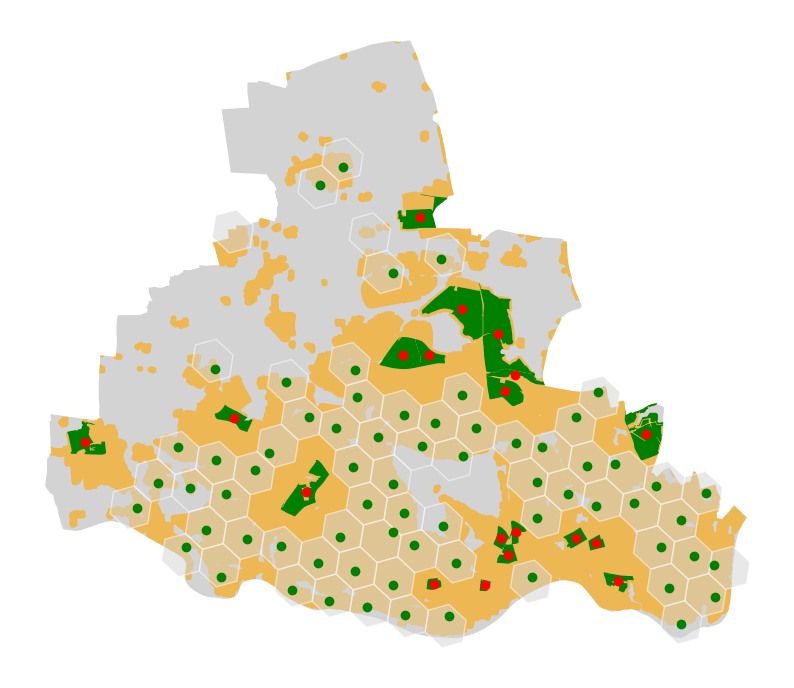

In [39]:
if debug:
    # Convert MultiPolygon to GeoDataFrame
    #neighbourhoods_gdf = gpd.GeoDataFrame(geometry=[geom for geom in neighbourhoods_gdf.geoms], crs="EPSG:4326")
    if isinstance(neighbourhoods_gdf, MultiPolygon):
        neighbourhoods_gdf = gpd.GeoDataFrame(geometry=[neighbourhoods_gdf], crs="EPSG:4326")
        neighbourhoods_gdf = neighbourhoods_gdf.explode()
    neighbourhood_centroids = neighbourhoods_gdf.copy()
    neighbourhood_centroids['geometry'] = neighbourhood_centroids['geometry'].centroid


    fig, ax = plt.subplots(figsize=(10, 10))
    location_gdf.plot(ax=ax, color='lightgrey')
    urban_areas.plot(ax=ax, color='orange', alpha=0.6, label='Urban Areas', legend=True)
    neighbourhoods_gdf.plot(ax=ax, color='green', label='LTNs',  legend=True)
    neighbourhood_centroids.plot(ax=ax, color='red', label='Neighbourhood Seed Points')
    hexagons.plot(ax=ax, color="lightgray", edgecolor="white", alpha=0.5, label="Hexagons")
    snapped_biketrack[snapped_biketrack['snap_status'] == 'snapped'].plot(ax=ax, color='green', label='Tesselation Seed Points')
    #snapped_biketrack[snapped_biketrack['snap_status'] == 'unsnapped'].plot(ax=ax, color='red', label='Unsnapped')
    #plt.legend()
    ax.axis('off')  # This removes the entire axis, including labels and ticks
    #plt.title(f"Snapped and Unsnapped Hexagon Centroids to Bike Track for {placeid}")
    plt.show()


Cities:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\b8008458\OneDrive - Newcastle University\2022 to 2023\PhD\networkGrowth\bikenwgrowth\code\functions.py:2279: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_buffered['geometry'] = gdf['geometry'].buffer(buffer_distance)


Plots saved to: ../../bikenwgrowth_external/plots/newcastle/


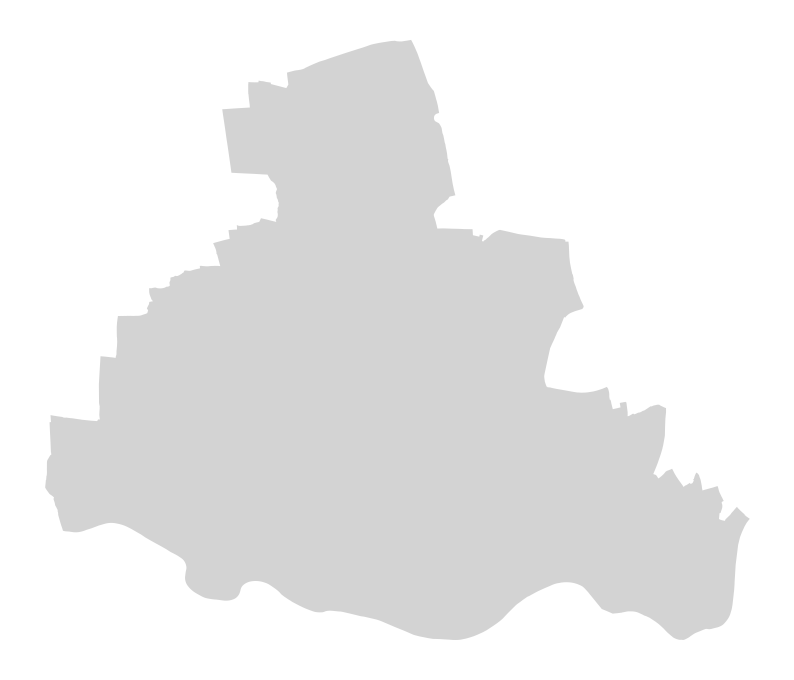

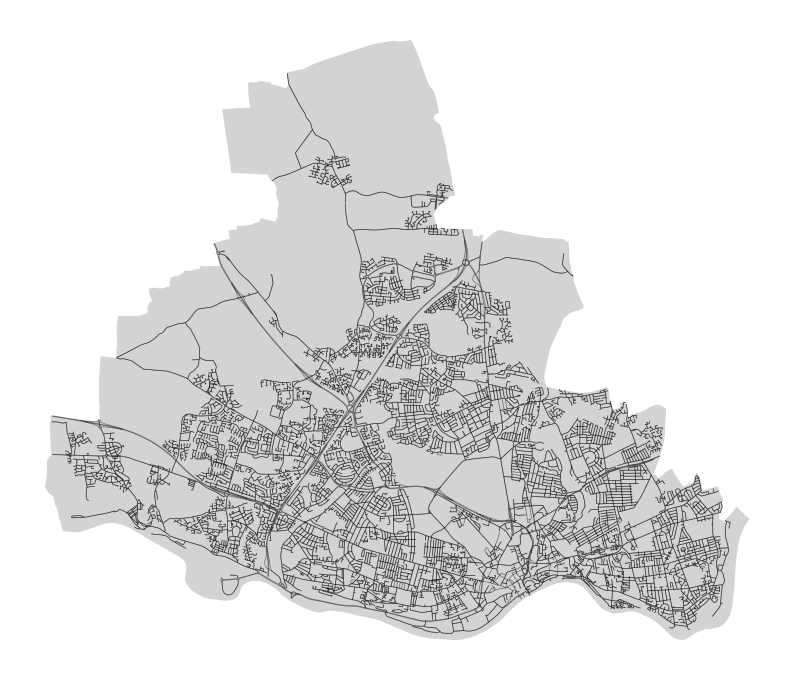

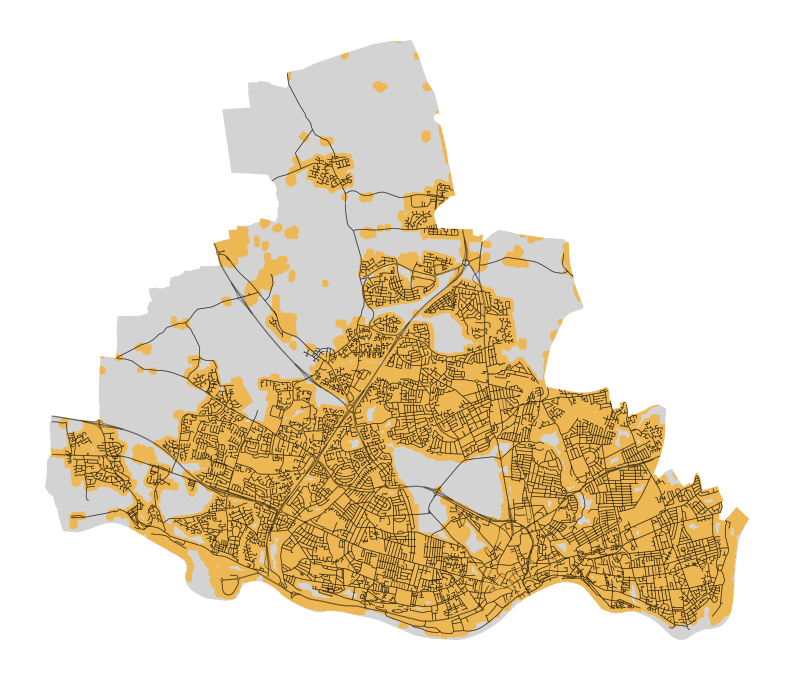

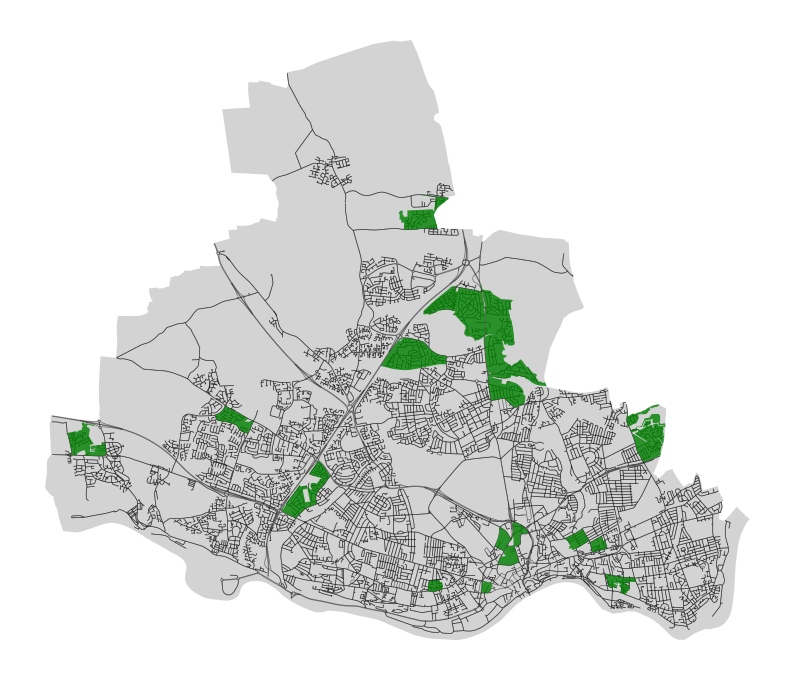

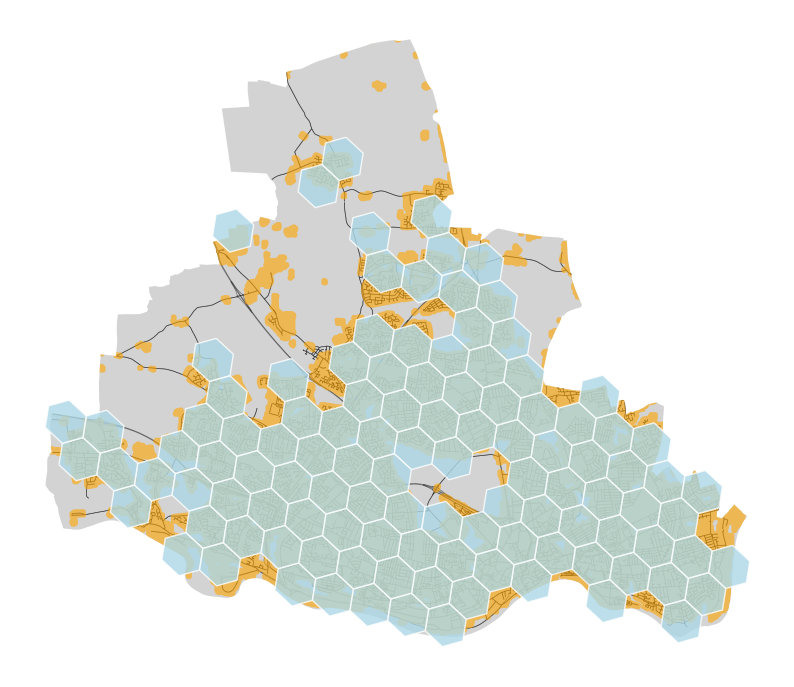

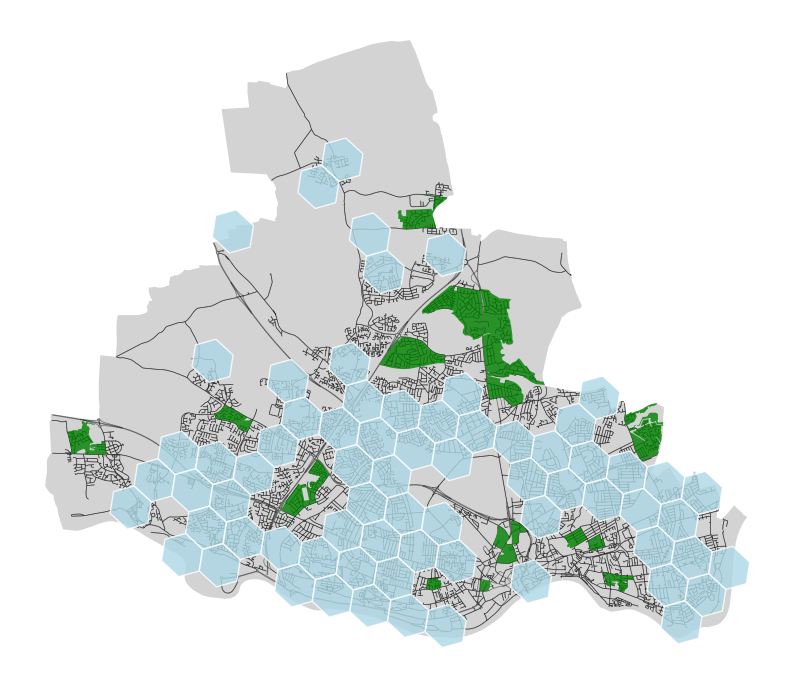

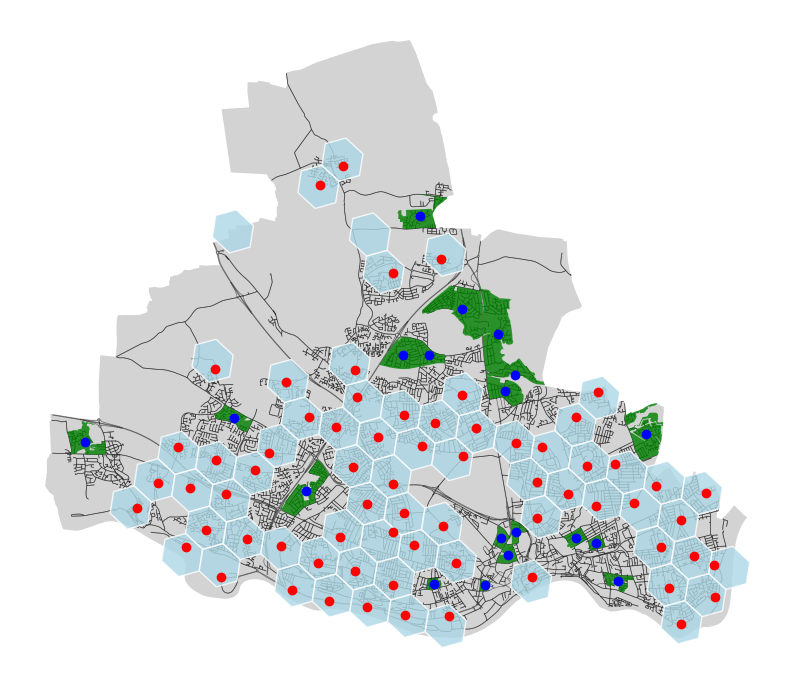

In [40]:
methods_plotting = True
if methods_plotting:
    for placeid, placeinfo in tqdm(cities.items(), desc="Cities"):    
        # plot city
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.axis('off')
        location = locations[placeid]
        location_gseries = gpd.GeoSeries([location])
        location_gdf = gpd.GeoDataFrame(geometry=location_gseries)
        location_gdf = location_gdf.set_crs(epsg=4326, inplace=True)
        location_gdf.plot(ax=ax, color='lightgrey')
        plt.savefig(PATH["plots"] + placeid + "/city_boundary.png", dpi=600, bbox_inches='tight')
        # plot city with roads on
        road_network = G_caralls[placeid]
        road_network_gdf = ox.graph_to_gdfs(road_network, nodes=False)
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.axis('off')
        location_gdf.plot(ax=ax, color='lightgrey')
        road_network_gdf.plot(ax=ax, color='black', alpha=0.5, linewidth=0.5)
        plt.savefig(PATH["plots"] + placeid + "/city_boundary_with_roads.png", dpi=600, bbox_inches='tight')
        # plot urban areas
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.axis('off')
        location_gdf.plot(ax=ax, color='lightgrey')
        urban_areas = get_urban_areas(placeinfo["nominatimstring"])
        urban_areas = urban_areas.clip(location_gdf.geometry[0])
        urban_areas.plot(ax=ax, color='orange', alpha=0.6, label='Urban Areas')
        road_network_gdf.plot(ax=ax, color='black', alpha=0.5, linewidth=0.5, zorder=1)
        plt.savefig(PATH["plots"] + placeid + "/urban_areas.png", dpi=600,  bbox_inches='tight')
        # plot neighbourhoods
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.axis('off')  
        location_gdf.plot(ax=ax, color='lightgrey', zorder=0)
        #neighbourhoods_gdf = gpd.GeoDataFrame(geometry=[geom for geom in neighbourhoods_gdf.geoms], crs="EPSG:4326")
        neighbourhoods_gdf.plot(ax=ax, color='green', label='LTNs', alpha=0.8, zorder=2)
        road_network_gdf.plot(ax=ax, color='black', alpha=0.5, linewidth=0.5, zorder=1)
        plt.savefig(PATH["plots"] + placeid + "/LTNs.png", dpi=600,  bbox_inches='tight')
        # plot hexagons
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.axis('off')
        location_gdf.plot(ax=ax, color='lightgrey', zorder=0)
        urban_areas.plot(ax=ax, color='orange', alpha=0.6, label='Urban Areas', zorder=2)
        clean_hexagons.plot(ax=ax, color="lightblue", edgecolor="white", alpha=0.8, zorder=3)
        road_network_gdf.plot(ax=ax, color='black', alpha=0.5, linewidth=0.5, zorder=1)
        plt.savefig(PATH["plots"] + placeid + "/hexagons.png", dpi=600,  bbox_inches='tight')
        # plot hexagons around LTNs
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.axis('off')
        location_gdf.plot(ax=ax, color='lightgrey', zorder=0)
        neighbourhoods_gdf.plot(ax=ax, color='green', label='LTNs', alpha=0.8,  zorder=2)
        hexagons.plot(ax=ax, color="lightblue", edgecolor="white", alpha=0.8, zorder=3)
        road_network_gdf.plot(ax=ax, color='black', alpha=0.5, linewidth=0.5, zorder=1)
        plt.savefig(PATH["plots"] + placeid + "/hexagons_around_LTNs.png", dpi=600,  bbox_inches='tight')
        # plot centroids
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.axis('off')
        location_gdf.plot(ax=ax, color='lightgrey', zorder=0)
        neighbourhoods_gdf.plot(ax=ax, color='green', label='LTNs', alpha=0.8, zorder=2)
        hexagons.plot(ax=ax, color="lightblue", edgecolor="white", alpha=0.8, zorder=3)
        snapped_biketrack.plot(ax=ax, color='red', label='Snapped Points', zorder=4)
        neighbourhood_centroids.plot(ax=ax, color='blue', label='Neighbourhood Centroids',  zorder=5)
        road_network_gdf.plot(ax=ax, color='black', alpha=0.5, linewidth=0.5, zorder=1)
        plt.savefig(PATH["plots"] + placeid + "/centroids.png", dpi=600,  bbox_inches='tight')



        base_path = os.path.join(PATH["plots"], placeid)
        image_files = [
            "urban_areas.png",
            "hexagons.png",
            "hexagons_around_LTNs.png",
            "centroids.png"
        ]
        titles = ["Define urban area", "Generate hexagons in urban areas", "Remove hexagons within LTNs", "Create and snap seed points"]
        image_paths = [os.path.join(base_path, img) for img in image_files]
        fig, axs = plt.subplots(1, 4, figsize=(20, 5)) 
        for ax, img_path, title in zip(axs, image_paths, titles):
            img = mpimg.imread(img_path)
            ax.imshow(img)
            ax.axis('off')  # Hide axes
            ax.set_title(title, fontsize=10)

        combined_path = os.path.join(base_path, "seed_point_methods_workflow.png")
        plt.tight_layout()
        plt.savefig(combined_path, dpi=600, bbox_inches='tight')
        plt.close()


        print("Plots saved to: " + PATH["plots"] + placeid + "/")
        

### Low Traffic Neighbourhood Centroids

In [ ]:
for placeid, placeinfo in tqdm(cities.items(), desc="Cities"):
    print(placeid + ": loading and moving LTNs")
    
    # Load LTN POIs
    if placeinfo["nominatimstring"] != '':
        location = ox.geocoder.geocode_to_gdf(placeinfo["nominatimstring"])
        if location.geometry[0].geom_type == 'MultiPolygon':
            location = location.explode(index_parts=False).reset_index(drop=True)
        location = fill_holes(extract_relevant_polygon(placeid, shapely.geometry.shape(location['geometry'][0])))
    else:
        # https://gis.stackexchange.com/questions/113799/how-to-read-a-shapefile-in-python
        shp = fiona.open(PATH["data"] + placeid + "/" + placeid + ".shp")
        first = next(iter(shp))
        try:
            location = Polygon(shapely.geometry.shape(first['geometry']))  # If shape file is given as linestring
        except:
            location = shapely.geometry.shape(first['geometry'])
    locations[placeid] = location
    
    G_caralls[placeid] = csv_to_ox_highway(PATH["data"] + placeid + "/", placeid, 'carall')
    G_caralls[placeid].graph["crs"] = 'epsg:4326'  # Needed for OSMNX's graph_to_gdfs in utils_graph.py
    G_caralls_simplified[placeid] = csv_to_ox(PATH["data"] + placeid + "/", placeid, 'carall_simplified')
    G_caralls_simplified[placeid].graph["crs"] = 'epsg:4326'  # Needed for OSMNX's graph_to_gdfs in utils_graph.py

    print(f"{placeid}: Loading and moving POIs")
    # Get the carall graph and location geometry
    location = locations[placeid]
    G_carall = G_caralls_simplified[placeid]

    # Load neighbourhoods and create GeoDataFrame for centroids
    neighbourhoods = load_neighbourhoods(PATH["data"] + placeid + "/")
    LTNs = gpd.GeoDataFrame(columns=['neighbourhood_id', 'geometry'], crs='EPSG:4326')  
    
    unique_id = 0 
    for name, gdf in neighbourhoods.items():  # Process each neighbourhood GeoDataFrame to get centroids, exit points, and neighbourhood IDs
        if gdf.empty:
            print(f"Warning: The GeoDataFrame for {name} is empty. Skipping...")
            continue
        print(f"Processing neighbourhoods in: {name}")

        # Assign a unique ID to each neighbourhood in the GeoDataFrame to reference throughout
        gdf['neighbourhood_id'] = range(unique_id, unique_id + len(gdf))
        if debug:
            print(f"Assigned neighbourhood_ids from {unique_id} to {unique_id + len(gdf) - 1} for {name}")

        # Get centroids to inherit 'neighbourhood_id'
        centroids_gdf = get_neighbourhood_centroids(gdf)
        LTNs = pd.concat([LTNs, centroids_gdf], ignore_index=True)
        unique_id += len(gdf)  # Increment by the number of neighbourhoods processed

    # Snap centroids to the closest nodes in the street network
    neighbourhood_nnids = set()
    for g in LTNs['geometry']:
        n = ox.distance.nearest_nodes(G_carall, g.x, g.y)
        if n not in neighbourhood_nnids and haversine((g.y, g.x), (G_carall.nodes[n]["y"], G_carall.nodes[n]["x"]), unit="m") <= snapthreshold:
            neighbourhood_nnids.add(n)
    # Add nearest_node column to LTNs by finding the nearest node for each centroid geometry
    LTNs['nearest_node'] = LTNs['geometry'].apply(
        lambda g: ox.distance.nearest_nodes(G_carall, g.x, g.y))  # We now have LTNs with 'neighbourhood_id', 'geometry', 'nearest_node' columns

    ltn_nnids = get_nearest_nodes_to_gdf(G_carall, LTNs)


    # save to file
    nnids_csv_path = PATH["data"] + placeid + "/" + placeid + '_poi_LTNs_nnids.csv'
    with open(nnids_csv_path, 'w') as f:
        for item in ltn_nnids:
            f.write("%s\n" % item)
    gpkg_output_path = PATH["data"] + placeid + "/" + placeid + '_poi_LTNs.gpkg'
    try:
        LTNs.to_file(gpkg_output_path, driver='GPKG')
    except Exception as e:
        print(f"Notice: Writing the LTN gdf did not work for {placeid}. Error: {e}")
    

Cities:   0%|          | 0/1 [00:00<?, ?it/s]

newcastle: loading and moving LTNs
newcastle: Loading and moving POIs
1 Cities loaded
Processing neighbourhoods in: newcastle
Assigned neighbourhood_ids from 0 to 215 for newcastle


C:\Users\b8008458\OneDrive - Newcastle University\2022 to 2023\PhD\networkGrowth\bikenwgrowth\code\functions.py:1774: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.geometry.centroid  # Calculate centroids for each polygon


### Combine LTNs and Tesselation

In [ ]:
ltn_and_tess_nnids = ltn_nnids + list(tess_nnids)
nnids_csv_path = PATH["data"] + placeid + "/" + placeid + '_poi_LTNs_tessellation_nnidscarall.csv'
with open(nnids_csv_path, 'w') as f:
    for item in ltn_and_tess_nnids:
        f.write("%s\n" % item)


combined_gdf = pd.concat([LTNs, snapped_biketrack], ignore_index=True)

combined_gpkg_output_path = PATH["data"] + placeid + "/" + placeid + '_poi_LTNs_tessellation.gpkg'
try:
    combined_gdf.to_file(combined_gpkg_output_path, driver='GPKG')
except Exception as e:
    print(f"Notice: Writing the combined gdf did not work for {placeid}. Error: {e}")

In [ ]:
combined_gdf.explore()

### Neighbourhood centroids

In [ ]:
""" for placeid, placeinfo in tqdm(cities.items(), desc="Cities"):
    print(placeid + ": loading and moving POIs")

    # We need the carall graph and location geometry
    location = locations[placeid]
    G_carall = G_caralls_simplified[placeid]

    # Load POIs from your local GeoPackage instead of OpenStreetMap
    gpkg_path = f"../../ltnConnect_external/exports/{placeinfo['nominatimstring']}_centroids.gpkg"

    # Read POIs from the local GeoPackage
    try:
        gdf = gpd.read_file(gpkg_path)
        print(gdf.crs)

        # Now snap to closest nodes in the street network and save the nearest node ids
        nnids = set()
        for g in gdf['geometry']:
            # Find nearest node in the carall network
            n = ox.distance.nearest_nodes(G_carall, g.x, g.y)
            if n not in nnids and haversine((g.y, g.x), (G_carall.nodes[n]["y"], G_carall.nodes[n]["x"]), unit="m") <= snapthreshold:
                nnids.add(n)
        nnids_csv_path = PATH["data"] + placeid + "/" + placeid + '_poi_' + 'neighbourhoods' + '_nnidscarall.csv'
        with open(nnids_csv_path, 'w') as f:
            for item in nnids:
                f.write("%s\n" % item)

        gdf = gdf.apply(lambda c: c.astype(str) if c.name != 'geometry' else c, axis=0)
        gpkg_output_path = PATH["data"] + placeid + "/" + placeid + '_poi_' + 'neighbourhoods' + '.gpkg'
        try:
            gdf.to_file(gpkg_output_path, driver='GPKG')
        except Exception as e:
            print(f"Notice: Writing the gdf did not work for {placeid}. Error: {e}")

        # Optionally plot for debugging purposes
        if debug:
            gdf.plot(color='red')

    except Exception as e:
        print(f"No Centroids created for {placeinfo['name']}. No POIs created. Error: {e}")
 """

### Joined Neighbourhoods and tesselation

In [ ]:
""" for placeid, placeinfo in tqdm(cities.items(), desc="Cities"):
    print(f"{placeid}: Processing tessellation and neighbourhood points")
    location = locations[placeid]

    # Get urban areas for seed points
    urban_areas = get_urban_areas(placeinfo["nominatimstring"])
    tess = Tessellation(urban_areas)
    tess.get_polygon()  # Optional plot for debugging
    hexagons = tess.hexagons(resolution=8)

    # Load neighbourhoods and create GeoDataFrame
    neighbourhoods = load_neighbourhoods(PATH["data"] + placeid + "/")
    neighbourhood_geoms = [geom for gdf in neighbourhoods.values() for geom in gdf['geometry'].values]
    neighbourhoods_gdf = gpd.GeoDataFrame(geometry=neighbourhood_geoms, crs="EPSG:4326")

    # Extract neighbourhood centroids
    all_centroids = gpd.GeoDataFrame(columns=['source', 'geometry'], crs='EPSG:4326')
    neighbourhood_centroids = gpd.GeoDataFrame(
        [{'source': 'neighbourhood', 'geometry': geom.centroid} for geom in neighbourhoods_gdf.geometry],
        crs="EPSG:4326"
    )
    all_centroids = pd.concat([all_centroids, neighbourhood_centroids], ignore_index=True)

    # Remove hexagons that intersect with neighbourhoods
    hexagons = hexagons[~hexagons.intersects(neighbourhoods_gdf.unary_union)]
    hexagon_centroids_gdf = gpd.GeoDataFrame(geometry=hexagons.centroid, crs=hexagons.crs)

    # Add tessellation centroids to the combined GeoDataFrame
    tessellation_centroids = gpd.GeoDataFrame(
        [{'source': 'tessellation', 'geometry': g} for g in hexagon_centroids_gdf['geometry']],
        crs="EPSG:4326"
    )
    all_centroids = pd.concat([all_centroids, tessellation_centroids], ignore_index=True)

    # Snap points to the carall network
    G_carall = G_caralls_simplified[placeid]
    nnids_carall = set()
    snapped_points_carall = []

    for g in all_centroids['geometry']:
        n = ox.distance.nearest_nodes(G_carall, g.x, g.y)
        distance_to_node = haversine((g.y, g.x), (G_carall.nodes[n]["y"], G_carall.nodes[n]["x"]), unit="m")
        if distance_to_node <= snapthreshold:
            snapped_points_carall.append({'geometry': Point(G_carall.nodes[n]["x"], G_carall.nodes[n]["y"]), 'source': 'snapped'})
            nnids_carall.add(n)
        else:
            snapped_points_carall.append({'geometry': g, 'source': 'unsnapped'})

    snapped_gdf_carall = gpd.GeoDataFrame(snapped_points_carall, crs=all_centroids.crs)

    # Save nnids to CSV
    nnids_csv_path = PATH["data"] + placeid + "/" + placeid + '_poi_' + 'tess_hoods_' + 'nnidscarall' + '.csv'
    with open(nnids_csv_path, 'w') as f:
        for item in nnids_carall:
            f.write(f"{item}\n")

    # Debug plot
    if debug:
        fig, ax = plt.subplots(figsize=(12, 12))
        hexagons.plot(ax=ax, color="lightgray", edgecolor="white", alpha=0.5, label="Hexagons")
        snapped_gdf_carall[snapped_gdf_carall['source'] == 'snapped'].plot(
            ax=ax, color='green', marker='o', label='Snapped Points', markersize=5
        )
        snapped_gdf_carall[snapped_gdf_carall['source'] == 'unsnapped'].plot(
            ax=ax, color='red', marker='x', label='Unsnapped Points', markersize=5
        )
        plt.legend()
        plt.title(f"Snapped Points for {placeid}")
        plt.show()

    # Save the combined points to GeoPackage
    gpkg_output_path = PATH["data"] + placeid + "/" + placeid + '_poi_' + 'tess_hoods' + '.gpkg'
    try:
        snapped_gdf_carall.to_file(gpkg_output_path, driver="GPKG")
    except Exception as e:
        print(f"Failed to save snapped GeoDataFrame for {placeid}. Error: {e}")
 """

### Railway stations/halts and bus stops

In [ ]:
# # Here POIs are downloaded and matched to the network. To ensure consistent reproducibility, we should download POIs only once, then load them locally. For now we leave it as is, as POIs are not expected to change fast.

# for placeid, placeinfo in tqdm(cities.items(), desc = "Cities"):
#     print(placeid + ": Creating POIs")
    
#     # We need the carall graph and location geometry
#     location = locations[placeid]
#     G_carall = G_caralls_simplified[placeid]
    
#     for poiid, poitag in poiparameters.items():
#         try:
#             gdf = ox.geometries.geometries_from_polygon(location, poitag)
#             gdf = gdf[gdf['geometry'].type == "Point"] # only consider points, no polygons etc
#             # Now snap to closest nodes in street network, save the nearest node ids
#             nnids = set()
#             for g in gdf['geometry']:
#                 n = ox.distance.nearest_nodes(G_carall, g.x, g.y) # !! get_nearest_node() had [y(lat),x(lon)], now nearest_nodes() has x(lon),y(lat)
#                 if not n in nnids and haversine((g.y, g.x), (G_carall.nodes[n]["y"], G_carall.nodes[n]["x"]), unit="m") <= snapthreshold:
#                     nnids.add(n)
#             with open(PATH["data"] + placeid + "/" + placeid + '_' + 'poi_' + poiid + '_nnidscarall.csv', 'w') as f:
#                 for item in nnids:
#                     f.write("%s\n" % item)
    
#             gdf = gdf.apply(lambda c: c.astype(str) if c.name != 'geometry' else c, axis=0)
#             try: # For some cities writing the gdf does not work (i.e. London, Manhattan)
#                 gdf.to_file(PATH["data"] + placeid + "/" + placeid + '_' + 'poi_' + poiid + '.gpkg', driver = 'GPKG')
#             except:
#                 print("Notice: Writing the gdf did not work for " + placeid)
#             if debug: gdf.plot(color = 'red')
#         except:
#             print("No stations in " + placeinfo["name"] + ". No POIs created.")

### Grid

Using code from: https://github.com/gboeing/osmnx-examples/blob/v0.11/notebooks/17-street-network-orientations.ipynb

In [ ]:
# for placeid, placeinfo in tqdm(cities.items(), desc  = "Cities"):
#     print(placeid + ": Creating grid")
    
#     location = locations[placeid]
    
    
    
#     # FIRST, determine the most common bearing, for the best grid orientation
#     G = G_caralls[placeid]
#     bearings = {}    
#     # calculate edge bearings
#     Gu = ox.bearing.add_edge_bearings(ox.get_undirected(G))

#     # weight bearings by length (meters)
#     city_bearings = []
#     for u, v, k, d in Gu.edges(keys = True, data = True):
#         city_bearings.extend([d['bearing']] * int(d['length']))
#     b = pd.Series(city_bearings)
#     bearings = pd.concat([b, b.map(reverse_bearing)]).reset_index(drop = 'True')

#     bins = np.arange(bearingbins + 1) * 360 / bearingbins
#     count = count_and_merge(bearingbins, bearings)
#     principalbearing = bins[np.where(count == max(count))][0]
#     if debug: 
#         print("Principal bearing: " + str(principalbearing))


#     # SECOND, construct the grid
#     G = G_caralls_simplified[placeid]

#     # 1) Get lat lon window, with buffer for snapping outside POIs
#     # https://stackoverflow.com/questions/7477003/calculating-new-longitude-latitude-from-old-n-meters
#     buf = max(((2*snapthreshold) / 6378000) * (180 / math.pi), 
#               ((2*snapthreshold) / 6378000) * (180 / math.pi) / math.cos(location.centroid.y * math.pi/180)
#              )
#     cities[placeid]["bbox"] = location.buffer(buf).bounds

#     # 2) Generate abstract grid points in window
#     # https://stackoverflow.com/questions/40342355/how-can-i-generate-a-regular-geographic-grid-using-python
#     # Set up projections
#     p_ll = pyproj.Proj('+proj=longlat +datum=WGS84')
#     aeqd_proj = '+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0'
#     p_mt = pyproj.Proj(aeqd_proj.format(lat=location.centroid.y, lon=location.centroid.x)) # equidistant projection

#     # Make the area larger to account for tilted grid
#     deltax = cities[placeid]["bbox"][2] - cities[placeid]["bbox"][0]
#     deltay = cities[placeid]["bbox"][3] - cities[placeid]["bbox"][1]
#     enlargefactor = 10

#     # Create corners of rectangle to be transformed to a grid
#     sw = shapely.geometry.Point((cities[placeid]["bbox"][0], cities[placeid]["bbox"][1]))
#     ne = shapely.geometry.Point((cities[placeid]["bbox"][2]+enlargefactor*deltax, cities[placeid]["bbox"][3]+enlargefactor*deltay))
    
#     # Project corners to target projection
#     transformed_sw = pyproj.transform(p_ll, p_mt, sw.x, sw.y) # Transform NW point to equidistant
#     transformed_ne = pyproj.transform(p_ll, p_mt, ne.x, ne.y) # .. same for SE

#     # Iterate over 2D area
#     principalbearing = principalbearing % 90 # Take it modulo 90 because it will be a square grid
#     if principalbearing > 45:
#         principalbearing -= 90 # Make bearing fall btw -45 and 45

#     xcoords = np.arange(transformed_sw[0], transformed_ne[0], gridl)
#     ycoords = np.arange(transformed_sw[1], transformed_ne[1], gridl)
#     xsize =  xcoords.size
#     ysize = ycoords.size
#     xcoords = np.tile(xcoords, ysize)
#     ycoords = np.repeat(ycoords, xsize)
#     gridpoints=[(x, y) for x, y in zip(xcoords, ycoords)]
#     new_points = rotate_grid(gridpoints, origin = transformed_sw, degrees = principalbearing)
    
#     # https://stackoverflow.com/questions/42459068/projecting-a-numpy-array-of-coordinates-using-pyproj
#     fx, fy = pyproj.transform(p_mt, p_ll, new_points[:,0], new_points[:,1])
#     gridpoints = np.dstack([fx, fy])[0]
#     if principalbearing >=0:
#         # If we rotated right, we need to shift everything to the left
#         gridpoints[:,0] -= 0.4*enlargefactor*deltax*math.sin(np.deg2rad(principalbearing))
#     else:
#         # If we rotated left, we need to shift everything down and to the right
#         gridpoints[:,0] += 0.4*enlargefactor*deltax*math.sin(np.deg2rad(principalbearing))
#         gridpoints[:,1] -= 0.4*enlargefactor*deltay

#     # Cut back to bounding box
#     mask = (gridpoints[:,0] >= cities[placeid]["bbox"][0]) & (gridpoints[:,0] <= cities[placeid]["bbox"][2]) & (gridpoints[:,1] >= cities[placeid]["bbox"][1]) & (gridpoints[:,1] <= cities[placeid]["bbox"][3])
#     gridpoints_cut = gridpoints[mask]
    
#     if debug:
#         fig = plt.figure(figsize=[2*6.4, 2*4.8])
#         ax = fig.add_axes([0, 0, 1, 1])
#         ax.set_aspect('equal', adjustable = 'datalim')
#         plt.plot([g[0] for g in gridpoints_cut], [g[1] for g in gridpoints_cut], ".", color = "red")

#     # 3) Snap grid points to map
#     nnids = set()
#     for g in gridpoints_cut:
#         n = ox.distance.nearest_nodes(G, g[0], g[1]) # !! get_nearest_node() had [y(lat),x(lon)], now nearest_nodes() has x(lon),y(lat)
#         if n not in nnids and haversine((g[1], g[0]), (G.nodes[n]["y"], G.nodes[n]["x"]), unit="m") <= snapthreshold:
#             nnids.add(n)
#     with open(PATH["data"] + placeid + "/" + placeid + '_poi_grid_nnidscarall.csv', 'w') as f:
#         for item in nnids:
#             f.write("%s\n" % item)
    
#     # 4) Save grid points to geopackage
#     geometry = [Point(xy) for xy in gridpoints_cut]  # Convert each point to a Shapely Point object
#     gdf = gpd.GeoDataFrame(geometry=geometry, crs="EPSG:4326")  # Create GeoDataFrame, assuming EPSG:4326 for WGS84
    
#     # Ensure all columns except geometry are strings for consistency with your POI export
#     gdf = gdf.apply(lambda c: c.astype(str) if c.name != 'geometry' else c, axis=0)

#     # Try writing the grid points to a GeoPackage
#     try:
#         gdf.to_file(PATH["data"] + placeid + "/" + placeid + '_poi_grid.gpkg', driver='GPKG')
#         print(f"Grid points written to GeoPackage for {placeid}")
#     except Exception as e:
#         print(f"Notice: Writing the grid points to GeoPackage did not work for {placeid}: {str(e)}")

#     if debug:
#         gdf.plot(color='blue')

### Population density (for now commented out as unfinished: data not reliable enough)

In [ ]:
# # https://medium.com/@danielmoyo/raster-data-in-python-part-i-reading-and-visualising-raster-data-95cb072fcbfa
# import rasterio

# densityfolder = "populationdensity"
# for placeid, placeinfo in cities.items():
#     raster_path = PATH["data"] + densityfolder + "/" + placeinfo['countryid'] + "_ppp_2020_UNadj.tif"
#     pop_raster = rasterio.open(raster_path)
    
#     cities[placeid]["bbox"] = location.bounds

#     def plot_raster(arr, title=None, figsize=(30,10)):
#         """ helper function to plot a raster array """
#         fig, ax = plt.subplots(figsize=figsize)
#         plt.imshow(arr)
#         plt.colorbar()
#         plt.title(f'{title}')
#         plt.xlabel('Column #')
#         plt.ylabel('Row #')
#         return fig, ax

#     pop_data = pop_raster.read(1)
#     pop_data[pop_data<0] = 0
#     pop_count = pop_data[pop_data>0].sum()
#     plot_raster(pop_data, title=pop_count)

In [ ]:
# # https://stackoverflow.com/questions/50191648/gis-geotiff-gdal-python-how-to-get-coordinates-from-pixel
# # https://gdal.org/api/gdaldataset_cpp.html#_CPPv4N11GDALDataset15GetGeoTransformEPd

# # Problems:
# # https://gis.stackexchange.com/questions/331908/notimplementederror-wrong-number-or-type-of-arguments-for-overloaded-function
# # https://gis.stackexchange.com/questions/44040/osr-python-testsr-importfromepsg4326-returns-empty-spatial-reference
# # https://www.programcreek.com/python/example/58591/osgeo.osr.SpatialReference


# def generate_latlons(raster_path):
#     # open the dataset and get the geo transform matrix
#     ds = gdal.Open(raster_path) 
#     xoffset, px_w, rot1, yoffset, px_h, rot2 = ds.GetGeoTransform()
#     ds_arr = ds.ReadAsArray()
    
#     x_arr = np.arange(0, ds_arr.shape[0], 1)
#     x_arr.shape = (len(x_arr), 1)
#     x_arr = np.repeat(x_arr, [ds_arr.shape[1]], axis=1)
    
#     y_arr = np.arange(0, ds_arr.shape[1], 1)
#     y_arr.shape = (1, len(y_arr))
#     y_arr = np.repeat(y_arr, [ds_arr.shape[0]], axis=0)
    
#     # supposing x and y are your pixel coordinate this 
#     # is how to get the coordinate in space.
#     lon_arr = xoffset + px_w * y_arr + rot1 * x_arr + px_w / 2.0
#     lat_arr = yoffset + px_h * y_arr + rot2 * x_arr + px_h / 2.0
    
#     return(lat_arr, lon_arr)

# for placeid, placeinfo in cities.items():
#     raster_path = PATH["data"] + densityfolder + "/" + placeinfo['countryid'] + "_ppp_2020_UNadj.tif"
#     pop_raster = rasterio.open(raster_path)
#     (lat, lon) = generate_latlons(raster_path)
    
# # To do: only read the relevant window
# # https://medium.com/@danielmoyo/raster-data-in-python-part-ii-working-with-geographic-coordinates-a368708de5f2

In [ ]:
# indices = np.where(pop_data == pop_data.max())
# c_x = indices[0].item()
# c_y = indices[1].item()

# delta = 60
# plot_raster(pop_data[c_x-delta:c_x+delta, c_y-delta:c_y+delta], title="Population density, Copenhagen")

In [ ]:
Audio(sound_file, autoplay=True)